# Temperature, Plane Body (numerical method)

In [106]:
import matplotlib.pyplot as plt
from matplotlib import cm
import copy

import numpy as np
from scipy.optimize import curve_fit
import scipy
import pandas as pd

from IPython.display import clear_output
import joblib

### 1. Initialization

#### 1.1. Physics parameters

In [107]:
# Whole plane body size 0 < x < a and 0 < y < b
a = 3
b = 3

# Grid will be (Nx-1) * (Ny-1) elements
Nx = 46
Ny = 46
number_of_elements = (Nx-1)*(Ny-1)

x_grid = np.outer(np.linspace(0, a, Nx), np.ones(Nx))
y_grid = np.outer(np.linspace(0, b, Ny), np.ones(Ny)).T

# Physical parameters
kx, ky, c, rho = 1.25, 1.25, 1, 1

#### 1.2. Initial temperature

In [108]:
# Parameters of "bell" temperatute distribution T(x,y) at the initial moment t=0
mu_x = 2.5
mu_y = 2.5
sigma_x = np.sqrt(1)
sigma_y = np.sqrt(1)

# Parameters of "plato" temperatute distribution T(x,y) at the initial moment t=0
plato_initial_level = 30.0

# Set initial temperatute distribution
U0_type = "plato modified" # "Gauss", "plato", "plato modified"

# edge conditions: Q = 0
if U0_type == "Gauss":
    U0_args = [mu_x, mu_y, sigma_x, sigma_y]
    plt_zlim_bottom, plt_zlim_top = 0.0, 1.1

# edge conditions: T = 0
if U0_type in ["plato", "plato modified"]:
    U0_args = [plato_initial_level]
    plt_zlim_bottom, plt_zlim_top = 0.0, plato_initial_level

#### 1.3. Numerical method (MMS) parameters

In [109]:
lx = x_grid[1][0]
ly = y_grid[0][1]

print(f"Space delta: lx = {lx}, ly = {ly}")

# delta = 4.47213595499958
# dt = round(max((lx**2*c*rho)/(kx*delta**2),(ly**2*c*rho)/(ky*delta**2)),4)
# Trange = np.arange(start=dt, stop=2.5+dt, step=dt)[:10]

dt = 0.05
Trange = np.round(np.arange(start=dt, stop=1.2+dt, step=dt),15)
delta = np.sqrt((lx**2*c*rho)/(kx*dt))

initial_temperature = "median" # "median", "polynomial"

bx = np.sqrt((c*rho)/(kx*dt))
by = np.sqrt((c*rho)/(ky*dt))

print(f"Time: dt = {dt},  delta = {round(delta,4)} \nTrange = {Trange}")

Space delta: lx = 0.06666666666666667, ly = 0.06666666666666667
Time: dt = 0.05,  delta = 0.2667 
Trange = [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2 ]


#### 1.4. Points of observations

In [110]:
def U0(x,y,*args):
    if U0_type == "Gauss":
        mu_x, mu_y, sigma_x, sigma_y = args[0], args[1], args[2], args[3]
        return np.exp(-(((x-mu_x)/sigma_x)**2 + ((y-mu_y)/sigma_y)**2)/2)
    if U0_type in ["plato", "plato modified"]:
        initial_level = args[0]
        # return a single value or an array
        return initial_level*np.ones((len(x),len(y))) if type(x) != np.float64 else initial_level

In [111]:
# Set point(s) to observe value(s) in. By default the observation point would be P(a/2.b/2)

if U0_type == "Gauss" and a == 5 and b == 5 and (Nx-1) % 5 == 0 and (Ny-1) % 5 == 0:
    Ut_anchor_points = np.zeros((len(Trange)+1,5))
    Ut_anchor_points[0] = np.array([
        U0(2.5,2.5,*U0_args),
        U0(3.5,2.5,*U0_args),
        U0(4.5,2.5,*U0_args),
        U0(3.5,3.5,*U0_args),
        U0(4.5,4.5,*U0_args),
    ])
elif U0_type in ["plato", "plato modified"] and a == 3 and b == 3 and (Nx-1) % 45 == 0 and (Ny-1) % 45 == 0:
    Ut_anchor_points = np.zeros((len(Trange)+1,5))
    Ut_anchor_points[0] = np.array([
        U0(np.float64(1.5),np.float64(1.5),*U0_args),
        U0(np.float64(2.1),np.float64(1.5),*U0_args),
        U0(np.float64(2.5),np.float64(1.5),*U0_args),
        U0(np.float64(2.1),np.float64(2.1),*U0_args),
        U0(np.float64(2.5),np.float64(2.5),*U0_args),
    ])
else:
    Ut_anchor_points = np.zeros((len(Trange)+1,1))
    Ut_anchor_points[0] = np.array([
        U0(np.float64(a/2),np.float64(b/2),*U0_args)
    ])

### 2. Display initial temperature distribution

In [112]:
def initial_temperature_as_polynomial(xy, a00, a10, a01, a20, a02): 
    x,y = xy
    
    # Define mathematical function for curve fitting 
    return a00 + a10*x + a01*y + a20*x**2 + a02*y**2 

In [113]:
def display_U0():
    fig = plt.figure(figsize=(18,8))
    cmap = cm.get_cmap("coolwarm").copy()
    cmap.set_under("white") # Color for values less than vmin

    # --------------- ANALYTICAL ---------------

    ax1 = fig.add_subplot(1, 3, 1, projection="3d")
    plt.title("Initial temperature at t = 0.0")

    ax1.plot_surface(
        X = x_grid, 
        Y = y_grid, 
        Z = U0(x_grid,y_grid,*U0_args),
        cmap=cm.coolwarm,
        vmin=0.0
    )
    ax1.set_ylabel("Y-axis")
    ax1.set_xlabel("X-axis")
    ax1.set_zlabel(r"$T_0(x,y)$")
    ax1.set_zlim(plt_zlim_bottom,plt_zlim_top)

    # --------------- MEAN TEMPERATURE ---------------

    median_coeffs = np.zeros((number_of_elements,3,3))

    x_median, y_median, z_median = np.zeros((Nx-1,Ny-1)), np.zeros((Nx-1,Ny-1)), np.zeros((Nx-1,Ny-1))

    element = 0
    for j in range(Ny-1):
        for i in range(Nx-1):
            x_median[i][j] = x_grid[i][j] + (x_grid[i+1][j]-x_grid[i][j])/2
            y_median[i][j] = y_grid[i][j] + (y_grid[i][j+1]-y_grid[i][j])/2
            z_median[i][j] = U0(x_median[i][j],y_median[i][j],*U0_args)
            
            median_coeffs[element][0][0] = z_median[i][j]
            element += 1

    ax2 = fig.add_subplot(1, 3, 2, projection="3d")
    plt.title("Median point temperature at t = 0")

    ax2.scatter3D(x_median, y_median, z_median, c=z_median, 
        cmap=cm.coolwarm
    )
    ax2.set_ylabel("Y-axis")
    ax2.set_xlabel("X-axis")
    ax2.set_zlabel(r"$T_0(x,y)$")
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_zlim(ax1.get_zlim())

    # --------------- POLINOMIAL ---------------

    ax3 = fig.add_subplot(1, 3, 3, projection="3d")
    plt.title("Polynomial temperature at t = 0")

    polynomial_coeffs = np.zeros((number_of_elements,3,3))
    points_per_element = 10

    element = 0
    for j in range(Ny-1):
        for i in range(Nx-1):
            x_local = np.outer(
                np.linspace(0, x_grid[i+1][j]-x_grid[i][j], points_per_element), 
                np.ones(points_per_element)
            ).flatten()
            y_local = np.outer(
                np.linspace(0, y_grid[i][j+1]-y_grid[i][j], points_per_element),
                np.ones(points_per_element)
            ).T.flatten()
            x_global = np.outer(
                np.linspace(x_grid[i][j], x_grid[i+1][j], points_per_element), 
                np.ones(points_per_element)
            ).flatten()
            y_global = np.outer(
                np.linspace(y_grid[i][j], y_grid[i][j+1], points_per_element),
                np.ones(points_per_element)
            ).T.flatten()
            if U0_type == "Gauss":
                z_global = U0(x_global,y_global,*U0_args).flatten()
            if U0_type in ["plato", "plato modified"]:
                z_global = U0(x_global,y_global,*U0_args)[0] # some kind of "flattening"

            # Coordinated (x,y) should be local, z --- global, data type --- ndarray
            popt, pcov = curve_fit(initial_temperature_as_polynomial, (x_local,y_local), z_global)
            # perr = np.sqrt(np.diag(pcov))

            polynomial_coeffs[element][0][0] = popt[0]
            polynomial_coeffs[element][1][0] = popt[1]
            polynomial_coeffs[element][0][1] = popt[2]
            polynomial_coeffs[element][2][0] = popt[3]        
            polynomial_coeffs[element][0][2] = popt[4]
            element += 1

            # Coordinated (x,y) should be local, z --- global, data type --- darrays
            x = x_local.reshape((points_per_element,points_per_element))
            y = y_local.reshape((points_per_element,points_per_element))
            ax3.plot_surface(
                X = x_global.reshape((points_per_element,points_per_element)), 
                Y = y_global.reshape((points_per_element,points_per_element)), 
                Z = popt[0] + popt[1]*x + popt[2]*y + popt[3]*x**2 + popt[4]*y**2,
                cmap=cm.Blues
            )
            ax3.set_ylabel("Y-axis")
            ax3.set_xlabel("X-axis")
            ax3.set_zlabel(r"$T_0(x,y)$")
            ax3.set_zlim(plt_zlim_bottom,plt_zlim_top)

    plt.savefig(f"Images/MSS: {U0_type} initial temperature.png", dpi=500, bbox_inches="tight")
    plt.show()

    return ax1, ax2, ax3, median_coeffs, polynomial_coeffs

/tmp/ipykernel_20478/4004771902.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("coolwarm").copy()


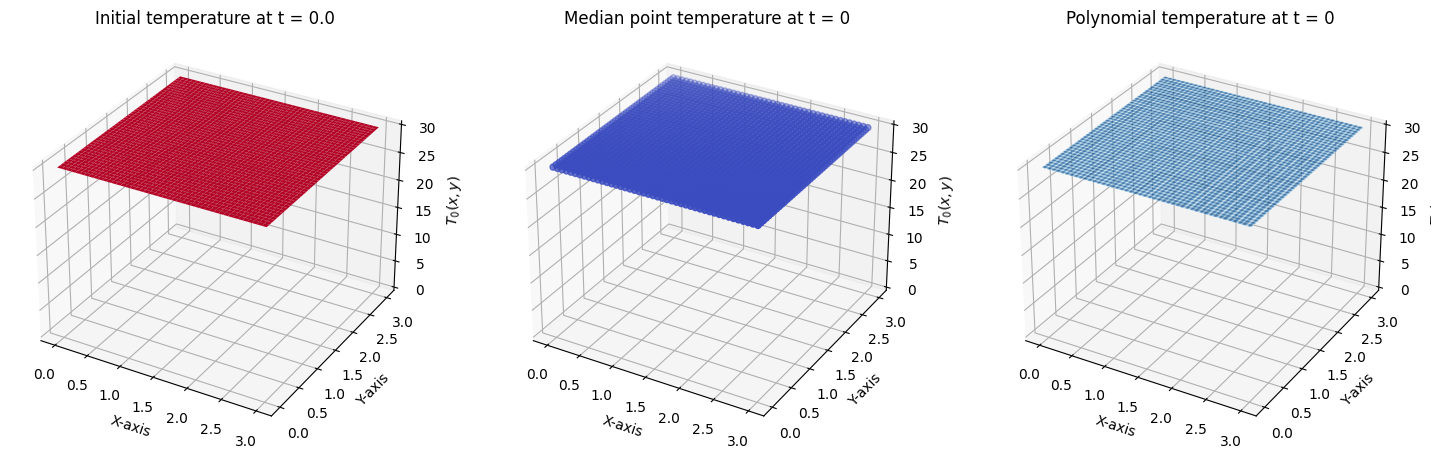

In [114]:
ax1, ax2, ax3, initial_median_coeffs, initial_polynomial_coeffs = display_U0()

### 3. Preliminary stage 

#### 3.1. Krylov functions

In [115]:
def K1x(x):
    return np.cosh(x*bx)

In [116]:
def K2x(x):
    return np.sinh(x*bx)/bx

In [117]:
def K1y(y):
    return np.cosh(y*by)

In [118]:
def K2y(y):
    return np.sinh(y*by)/by

#### 3.2. Decomposition of Krylov functions

In [119]:
def decompose_into_polynomial(lx,ly,bx,by):
    fx = np.zeros(3)
    fy = np.zeros(3)
    hx = np.zeros(3)
    hy = np.zeros(3)

    Fx, Fx_free = np.zeros((3,3)), np.zeros(3)
    Fy, Fy_free = np.zeros((3,3)), np.zeros(3)
    Hx, Hx_free = np.zeros((3,3)), np.zeros(3)
    Hy, Hy_free = np.zeros((3,3)), np.zeros(3)

    # ---------------------------- Fx ----------------------------

    Fx[0][0], Fx[0][1], Fx[0][2] = lx, lx**2/2, lx**3/3
    Fx[1][0], Fx[1][1], Fx[1][2] = lx**2/2, lx**3/3, lx**4/4
    Fx[2][0], Fx[2][1], Fx[2][2] = lx**3/3, lx**4/4, lx**5/5

    Fx_free[0] = np.sinh(lx*bx)/bx
    Fx_free[1] = lx*np.sinh(lx*bx)/bx - (np.cosh(lx*bx) - 1)/bx**2
    Fx_free[2] = lx**2*np.sinh(lx*bx)/bx - 2*lx*np.cosh(lx*bx)/bx**2 + 2*np.sinh(lx*bx)/bx**3

    # ---------------------------- Fy ----------------------------

    Fy[0][0], Fy[0][1], Fy[0][2] = ly, ly**2/2, ly**3/3
    Fy[1][0], Fy[1][1], Fy[1][2] = ly**2/2, ly**3/3, ly**4/4
    Fy[2][0], Fy[2][1], Fy[2][2] = ly**3/3, ly**4/4, ly**5/5

    Fy_free[0] = np.sinh(ly*by)/by
    Fy_free[1] = ly*np.sinh(ly*by)/by - (np.cosh(ly*by) - 1)/by**2
    Fy_free[2] = ly**2*np.sinh(ly*by)/by - 2*ly*np.cosh(ly*by)/by**2 + 2*np.sinh(ly*by)/by**3

    # ---------------------------- Hx ----------------------------

    Hx[0][0], Hx[0][1], Hx[0][2] = lx, lx**2/2, lx**3/3
    Hx[1][0], Hx[1][1], Hx[1][2] = lx**2/2, lx**3/3, lx**4/4
    Hx[2][0], Hx[2][1], Hx[2][2] = lx**3/3, lx**4/4, lx**5/5

    Hx_free[0] = (np.cosh(lx*bx) - 1)/bx**2
    Hx_free[1] = lx*np.cosh(lx*bx)/bx**2 - np.sinh(lx*bx)/bx**3
    Hx_free[2] = lx**2*np.cosh(lx*bx)/bx**2 - 2*lx*np.sinh(lx*bx)/bx**3 + 2*(np.cosh(lx*bx) - 1)/bx**4

    # ---------------------------- Hy ----------------------------

    Hy[0][0], Hy[0][1], Hy[0][2] = ly, ly**2/2, ly**3/3
    Hy[1][0], Hy[1][1], Hy[1][2] = ly**2/2, ly**3/3, ly**4/4
    Hy[2][0], Hy[2][1], Hy[2][2] = ly**3/3, ly**4/4, ly**5/5

    Hy_free[0] = (np.cosh(ly*by) - 1)/by**2
    Hy_free[1] = ly*np.cosh(ly*by)/by**2 - np.sinh(ly*by)/by**3
    Hy_free[2] = ly**2*np.cosh(ly*by)/by**2 - 2*ly*np.sinh(ly*by)/by**3 + 2*(np.cosh(ly*by) - 1)/by**4

    fx = np.linalg.solve(Fx,Fx_free)
    fy = np.linalg.solve(Fy,Fy_free)
    hx = np.linalg.solve(Hx,Hx_free)
    hy = np.linalg.solve(Hy,Hy_free)

    return fx,fy,hx,hy

In [120]:
def display_Krylov_decomposition(fx,fy,hx,hy):
    x = np.arange(0,lx,0.001)
    y = np.arange(0,ly,0.001)

    plt.figure(figsize=(12,10))
    for (plot_number,title,x_label,points,b_coeff,coeffs,Krylov) in zip(
            [1,2,3,4],
            [r"$K_1(x)$",r"$K_2(x)$",r"$K_1(y)$",r"$K_2(y)$"],
            [r"$l_xb_x$",r"$l_xb_x$",r"$l_yb_y$",r"$l_yb_y$"],
            [x,x,y,y],
            [bx,bx,by,by],
            [fx,hx,fy,hy],
            [K1x,K2x,K1y,K2y]
        ):
        plt.subplot(2,2,plot_number)
        plt.plot(points*b_coeff, Krylov(points))
        plt.plot(points*b_coeff, coeffs[0] + coeffs[1]*points + coeffs[2]*points**2)
        plt.grid()
        plt.xlabel(x_label)
        plt.legend([f"{title} plot", f"Decomposed {title}"])

    plt.savefig("Images/MSS: Krylov decomposition.png", dpi=500, bbox_inches="tight")
    
    return plt.show()

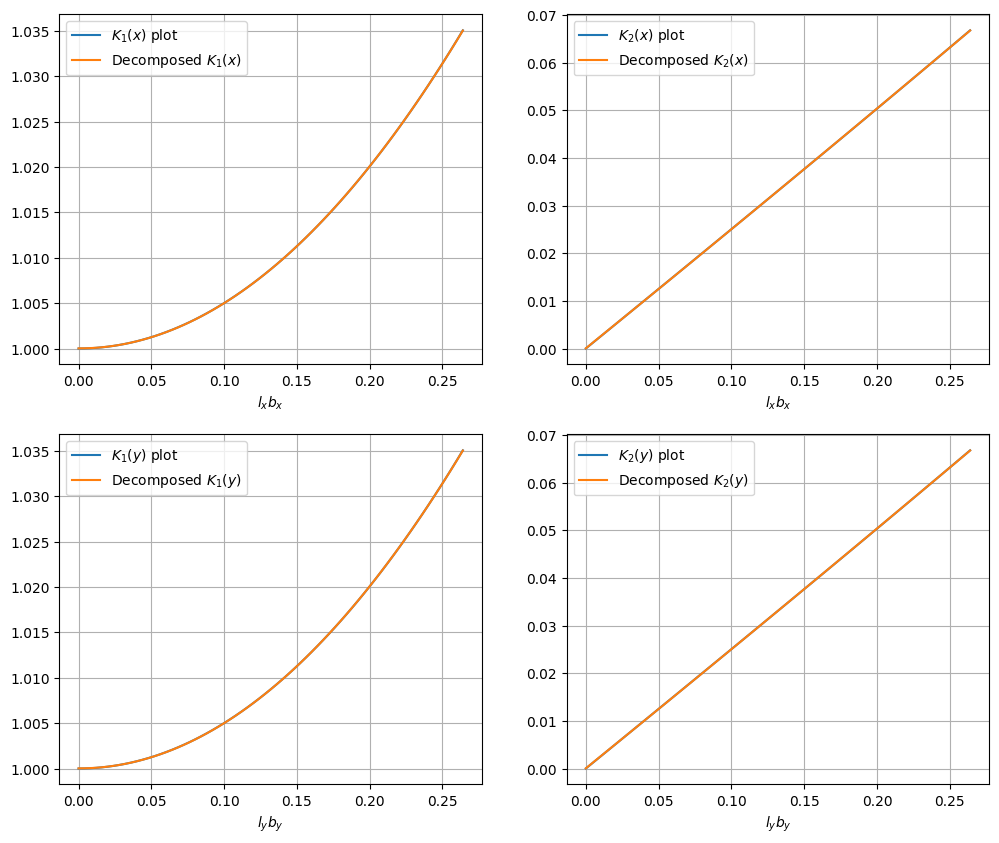

In [121]:
fx,fy,hx,hy = decompose_into_polynomial(lx,ly,bx,by)
display_Krylov_decomposition(fx,fy,hx,hy)

### 4. Set & solve numerical equations

#### 4.1. Variables numeration

![image](Images/0:%20Variables%20numeration.png)

#### 4.2. Elements numeration (e.g., Nx=4, Ny=4)

![image](Images/0:%20Elements%20numeration.png)

#### 4.3. Run the main algorithm

In [122]:
def transfer_matrix_equations(t,alpha,number_of_elements):
    A = np.zeros((number_of_elements*10,number_of_elements*10))
    B = np.zeros(number_of_elements*10)

    for element in range(number_of_elements):
        # Field equations
        A[0 + element*10][4 + element*10] = 1
        A[0 + element*10][0 + element*10] = -K1x(lx)
        A[0 + element*10][1 + element*10] = K2x(lx)/kx
        A[0 + element*10][8 + element*10] = -(1 - K1x(lx))
        A[0 + element*10][9 + element*10] = -(1 - K1x(lx))
        B[0 + element*10] = (alpha[t-1][element][0][0] + 2*alpha[t-1][element][2][0]/bx**2) * (1 - K1x(lx)) + alpha[t-1][element][1][0]*(lx - K2x(lx)) + alpha[t-1][element][2][0]*lx**2

        A[1 + element*10][5 + element*10] = 1
        A[1 + element*10][0 + element*10] = kx*bx**2*K2x(lx)
        A[1 + element*10][1 + element*10] = - K1x(lx)
        A[1 + element*10][8 + element*10] = -kx*bx**2*K2x(lx)
        A[1 + element*10][9 + element*10] = -kx*bx**2*K2x(lx)
        B[1 + element*10] = (alpha[t-1][element][0][0] + 2*alpha[t-1][element][2][0]/bx**2) * kx*bx**2*K2x(lx)- kx*alpha[t-1][element][1][0]*(1 - K1x(lx)) - 2*kx*alpha[t-1][element][2][0]*lx

        A[2 + element*10][6 + element*10] = 1
        A[2 + element*10][2 + element*10] = -K1y(ly)
        A[2 + element*10][3 + element*10] = K2y(ly)/ky
        A[2 + element*10][8 + element*10] = (1 - K1y(ly))
        B[2 + element*10] = 2*alpha[t-1][element][0][2]/by**2 * (1 - K1y(ly)) + alpha[t-1][element][0][1]*(ly - K2y(ly)) + alpha[t-1][element][0][2]*ly**2

        A[3 + element*10][7 + element*10] = 1
        A[3 + element*10][2 + element*10] = ky*by**2*K2y(ly)
        A[3 + element*10][3 + element*10] = -K1y(ly)
        A[3 + element*10][8 + element*10] = ky*by**2*K2y(ly)
        B[3 + element*10] = 2*alpha[t-1][element][0][2]/by**2 * ky*by**2*K2y(ly) - ky*alpha[t-1][element][0][1]*(1 - K1y(ly)) - 2*ky*alpha[t-1][element][0][2]*ly

        # Tci & Ai equations
        A[4 + element*10][8 + element*10] = -(1 - K1x(lx/2))
        A[4 + element*10][9 + element*10] = K1x(lx/2)
        A[4 + element*10][0 + element*10] = -K1x(lx/2)
        A[4 + element*10][1 + element*10] = K2x(lx/2)/kx
        B[4 + element*10] = (alpha[t-1][element][0][0] + 2*alpha[t-1][element][2][0]/bx**2) * (1 - K1x(lx/2)) + alpha[t-1][element][1][0]*(lx/2 - K2x(lx/2)) + alpha[t-1][element][2][0]*(lx/2)**2

        A[5 + element*10][8 + element*10] = (1 - K1y(ly/2))
        A[5 + element*10][9 + element*10] = 1
        A[5 + element*10][2 + element*10] = -K1y(ly/2)
        A[5 + element*10][3 + element*10] = K2y(ly/2)/ky
        B[5 + element*10] = 2*alpha[t-1][element][0][2]/by**2 * (1 - K1y(ly/2)) + alpha[t-1][element][0][1]*(ly/2 - K2y(ly/2)) + alpha[t-1][element][0][2]*(ly/2)**2

        # Transfer equations
        
        # Left edge
        if element % (Nx-1) == 0:
            if U0_type == "plato": A[6 + element*10][0 + element*10] = 1 # T = 0
            if U0_type == "Gauss": A[6 + element*10][1 + element*10] = 1 # Q = 0
            if U0_type == "plato modified": A[6 + element*10][1 + element*10] = 1 # Q = 0
        else:
            A[6 + element*10][5 + (element-1)*10] = 1
            A[6 + element*10][1 + element*10] = -1
        
        # Bottom edge
        if element // (Nx - 1) == 0:
            if U0_type in ["plato", "plato modified"]: A[7 + element*10][2 + element*10] = 1 # T = 0
            if U0_type == "Gauss": A[7 + element*10][3 + element*10] = 1 # Q = 0
        else:
            A[7 + element*10][7 + (element-(Nx-1))*10] = 1
            A[7 + element*10][3 + element*10] = -1

        # Right edge
        if element % (Nx-1) == (Nx-1)-1:
            if U0_type in ["plato", "plato modified"]: A[8 + element*10][4 + element*10] = 1 # T = 0
            if U0_type == "Gauss": A[8 + element*10][5 + element*10] = 1 # Q = 0
        else:
            A[8 + element*10][4 + element*10] = 1
            A[8 + element*10][0 + (element+1)*10] = -1
        
        # Top edge
        if element // (Nx - 1) == (Ny-1)-1:
            if U0_type in ["plato", "plato modified"]: A[9 + element*10][6 + element*10] = 1 # T = 0
            if U0_type == "Gauss": A[9 + element*10][7 + element*10] = 1 # Q = 0
        else:
            A[9 + element*10][6 + element*10] = 1
            A[9 + element*10][2 + (element+(Nx-1))*10] = -1

    return A, B

In [123]:
def sparse_transfer_matrix_equations(t,alpha,number_of_elements):
    A = scipy.sparse.lil_matrix((number_of_elements*10,number_of_elements*10))
    B = scipy.sparse.lil_matrix((number_of_elements*10,1))

    for element in range(number_of_elements):
        # Field equations
        A[0 + element*10,4 + element*10] = 1
        A[0 + element*10,0 + element*10] = -K1x(lx)
        A[0 + element*10,1 + element*10] = K2x(lx)/kx
        A[0 + element*10,8 + element*10] = -(1 - K1x(lx))
        A[0 + element*10,9 + element*10] = -(1 - K1x(lx))
        B[0 + element*10] = (alpha[t-1][element][0][0] + 2*alpha[t-1][element][2][0]/bx**2) * (1 - K1x(lx)) + alpha[t-1][element][1][0]*(lx - K2x(lx)) + alpha[t-1][element][2][0]*lx**2

        A[1 + element*10,5 + element*10] = 1
        A[1 + element*10,0 + element*10] = kx*bx**2*K2x(lx)
        A[1 + element*10,1 + element*10] = - K1x(lx)
        A[1 + element*10,8 + element*10] = -kx*bx**2*K2x(lx)
        A[1 + element*10,9 + element*10] = -kx*bx**2*K2x(lx)
        B[1 + element*10] = (alpha[t-1][element][0][0] + 2*alpha[t-1][element][2][0]/bx**2) * kx*bx**2*K2x(lx)- kx*alpha[t-1][element][1][0]*(1 - K1x(lx)) - 2*kx*alpha[t-1][element][2][0]*lx

        A[2 + element*10,6 + element*10] = 1
        A[2 + element*10,2 + element*10] = -K1y(ly)
        A[2 + element*10,3 + element*10] = K2y(ly)/ky
        A[2 + element*10,8 + element*10] = (1 - K1y(ly))
        B[2 + element*10] = 2*alpha[t-1][element][0][2]/by**2 * (1 - K1y(ly)) + alpha[t-1][element][0][1]*(ly - K2y(ly)) + alpha[t-1][element][0][2]*ly**2

        A[3 + element*10,7 + element*10] = 1
        A[3 + element*10,2 + element*10] = ky*by**2*K2y(ly)
        A[3 + element*10,3 + element*10] = -K1y(ly)
        A[3 + element*10,8 + element*10] = ky*by**2*K2y(ly)
        B[3 + element*10] = 2*alpha[t-1][element][0][2]/by**2 * ky*by**2*K2y(ly) - ky*alpha[t-1][element][0][1]*(1 - K1y(ly)) - 2*ky*alpha[t-1][element][0][2]*ly

        # Tci & Ai equations
        A[4 + element*10,8 + element*10] = -(1 - K1x(lx/2))
        A[4 + element*10,9 + element*10] = K1x(lx/2)
        A[4 + element*10,0 + element*10] = -K1x(lx/2)
        A[4 + element*10,1 + element*10] = K2x(lx/2)/kx
        B[4 + element*10] = (alpha[t-1][element][0][0] + 2*alpha[t-1][element][2][0]/bx**2) * (1 - K1x(lx/2)) + alpha[t-1][element][1][0]*(lx/2 - K2x(lx/2)) + alpha[t-1][element][2][0]*(lx/2)**2

        A[5 + element*10,8 + element*10] = (1 - K1y(ly/2))
        A[5 + element*10,9 + element*10] = 1
        A[5 + element*10,2 + element*10] = -K1y(ly/2)
        A[5 + element*10,3 + element*10] = K2y(ly/2)/ky
        B[5 + element*10] = 2*alpha[t-1][element][0][2]/by**2 * (1 - K1y(ly/2)) + alpha[t-1][element][0][1]*(ly/2 - K2y(ly/2)) + alpha[t-1][element][0][2]*(ly/2)**2

        # Transfer equations
        
        # Left edge
        if element % (Nx-1) == 0:
            if U0_type == "plato": A[6 + element*10,0 + element*10] = 1 # T = 0
            if U0_type == "Gauss": A[6 + element*10,1 + element*10] = 1 # Q = 0
            if U0_type == "plato modified": A[6 + element*10,1 + element*10] = 1 # Q = 0
        else:
            A[6 + element*10,5 + (element-1)*10] = 1
            A[6 + element*10,1 + element*10] = -1

        # Bottom edge
        if element // (Nx - 1) == 0:
            if U0_type in ["plato", "plato modified"]: A[7 + element*10,2 + element*10] = 1 # T = 0
            if U0_type == "Gauss": A[7 + element*10,3 + element*10] = 1 # Q = 0
        else:
            A[7 + element*10,7 + (element-(Nx-1))*10] = 1
            A[7 + element*10,3 + element*10] = -1

        # Right edge
        if element % (Nx-1) == (Nx-1)-1:
            if U0_type in ["plato", "plato modified"]: A[8 + element*10,4 + element*10] = 1 # T = 0
            if U0_type == "Gauss": A[8 + element*10,5 + element*10] = 1 # Q = 0
        else:
            A[8 + element*10,4 + element*10] = 1
            A[8 + element*10,0 + (element+1)*10] = -1
        
        # Top edge
        if element // (Nx - 1) == (Ny-1)-1:
            if U0_type in ["plato", "plato modified"]: A[9 + element*10,6 + element*10] = 1 # T = 0
            if U0_type == "Gauss": A[9 + element*10,7 + element*10] = 1 # Q = 0
        else:
            A[9 + element*10,6 + element*10] = 1
            A[9 + element*10,2 + (element+(Nx-1))*10] = -1

    return A, B

In [124]:
def Txi(x,t,X,element,alpha):
    return X[0 + element*10]*K1x(x) - X[1 + element*10]*K2x(x)/kx + (alpha[t-1][element][0][0] + 2*alpha[t-1][element][2][0]/bx**2 + X[9 + element*10] + X[8 + element*10])*(1 - K1x(x)) + alpha[t-1][element][1][0]*(x - K2x(x)) + alpha[t-1][element][2][0]*x**2

In [125]:
def Tyi(y,t,X,element,alpha):
    return X[2 + element*10]*K1y(y) - X[3 + element*10]*K2y(y)/ky + (2*alpha[t-1][element][0][2]/by**2 - X[8 + element*10])*(1 - K1y(y)) + alpha[t-1][element][0][1]*(y - K2y(y)) + alpha[t-1][element][0][2]*y**2

In [126]:
def compare_temperature_decomposition(t,X,alpha):
    plt.figure(figsize=(12,5))
    points_per_element = 20
    
    plt.subplot(1,2,1) # X-axis = const (a/2)
    x_location = 0
    y_location = np.linspace(0,ly,points_per_element)
    for element in [(Nx-1)//2 + (Nx-1)*i for i in range((Ny-1))]:
        Ty_plot, = plt.plot(
            y_location + ly*(element//(Nx-1)),
            Txi(x_location,t,X,element,alpha) + Tyi(y_location,t,X,element,alpha) - X[9 + element*10],
            color="black",
            label=r"$T_i(a/2,y)$"
        )
    for element in [(Nx-1)//2 + (Nx-1)*i for i in range((Ny-1))]:
        x, y = x_location, y_location
        decomposed_Ty_plot, = plt.plot(
            y_location + ly*(element//(Nx-1)),
            alpha[t][element][0][0] + alpha[t][element][1][0]*x + alpha[t][element][0][1]*y + alpha[t][element][2][0]*x**2 + alpha[t][element][0][2]*y**2,
            color="orange",
            label=r"Polynomial decomposition of $T_i(a/2,y)$"
        )
    plt.legend(handles=[Ty_plot, decomposed_Ty_plot])
    plt.ylim(plt_zlim_bottom,plt_zlim_top)
    plt.xlabel("Y-axis")
    plt.ylabel("Z-axis")

    plt.subplot(1,2,2) # Y-axis = const (b/2)
    x_location = np.linspace(0,lx,points_per_element)
    y_location = 0
    for element in [((Ny-1)//2) * (Nx-1) + i for i in range((Nx-1))]:
        Tx_plot, = plt.plot(
            x_location + lx*(element - ((Ny-1)//2) * (Nx-1)),
            Txi(x_location,t,X,element,alpha) + Tyi(y_location,t,X,element,alpha) - X[9 + element*10],
            color="black",
            label=r"$T_i(x,b/2)$"
        )
    for element in [((Ny-1)//2) * (Nx-1) + i for i in range((Nx-1))]:
        x, y = x_location, y_location
        decomposed_Tx_plot, = plt.plot(
            x_location + lx*(element - ((Ny-1)//2) * (Nx-1)),
            alpha[t][element][0][0] + alpha[t][element][1][0]*x + alpha[t][element][0][1]*y + alpha[t][element][2][0]*x**2 + alpha[t][element][0][2]*y**2,
            color="orange",
            label=r"Polynomial decomposition of $T_i(x,b/2)$"
        )
    plt.legend(handles=[Tx_plot, decomposed_Tx_plot])
    plt.ylim(plt_zlim_bottom,plt_zlim_top)
    plt.xlabel("X-axis")
    plt.ylabel("Z-axis")

    plt.savefig("Images/MSS: X-axis Y-axis fixed", dpi=500, bbox_inches="tight")
    
    return plt.show()

In [127]:
def run_numerical_method(alpha,Ut_anchor_points,T_distribution,compare_decomposition):
    print(f"Progress bar: 0%")
    for t in range(1,len(Trange)+1):
        # A, B = transfer_matrix_equations(t,alpha,number_of_elements)
        # X = np.linalg.solve(A, B)

        # Faster way to solve sparse matrices
        A, B = sparse_transfer_matrix_equations(t,alpha,number_of_elements)
        X = scipy.sparse.linalg.spsolve(A, B)

        # Save X in the last moment to display it more detailed later
        if t == len(Trange):
            X_anchor = copy.deepcopy(X)
        
        # Reesrimate values for the next moment of time
        for element in range(number_of_elements):
            alpha_x = X[0 + element*10] - alpha[t-1][element][0][0] - 2*alpha[t-1][element][2][0]/bx**2 - X[9 + element*10] - X[8 + element*10]
            beta_x = -X[1 + element*10]/kx - alpha[t-1][element][1][0]
            alpha_y = X[2 + element*10] - 2*alpha[t-1][element][0][2]/by**2 + X[8 + element*10]
            beta_y = -X[3 + element*10]/ky - alpha[t-1][element][0][1]

            # Outdated way to calculate alpha[t][element][0][0]
            # alpha[t][element][0][0] = alpha[t-1][element][0][0] + alpha_x*fx[0] + beta_x*hx[0] + 2*alpha[t-1][element][2][0]/bx**2 + alpha_y*fy[0] + beta_y*hy[0] + 2*alpha[t-1][element][0][2]/by**2
            # print(alpha[t][element][0][0])

            alpha[t][element][1][0] = alpha_x*fx[1] + beta_x*hx[1] + alpha[t-1][element][1][0]
            alpha[t][element][2][0] = alpha_x*fx[2] + beta_x*hx[2] + alpha[t-1][element][2][0]
            alpha[t][element][0][1] = alpha_y*fy[1] + beta_y*hy[1] + alpha[t-1][element][0][1]
            alpha[t][element][0][2] = alpha_y*fy[2] + beta_y*hy[2] + alpha[t-1][element][0][2]

            T_0x = alpha[t-1][element][0][0] + alpha_x*fx[0] + beta_x*hx[0] + 2*alpha[t-1][element][2][0]/bx**2 + X[9 + element*10] + X[8 + element*10]
            T_0y = alpha_y*fy[0] + beta_y*hy[0] + 2*alpha[t-1][element][0][2]/by**2 - X[8 + element*10]

            alpha[t][element][0][0] = (T_0x + T_0y)/2 - alpha[t][element][1][0]*lx/4 - alpha[t][element][2][0]*lx**2/8 - alpha[t][element][0][1]*ly/4 - alpha[t][element][0][2]*ly**2/8

        # Check correctness of decomposition T_current for the set time moment t (compare_decomposition[1]) into polynomial T_prev for the moment t + 1
        if compare_decomposition[0] == True and t == compare_decomposition[1]: 
            compare_temperature_decomposition(compare_decomposition[1],X,alpha)

        # Capture values in the 'anchor' points of observations
        if len(Ut_anchor_points[-1]) == 5:
            if U0_type == "Gauss" and a == 5 and b == 5 and (Nx-1) % 5 == 0 and (Ny-1) % 5 == 0:
                P1_element_index = int((2.5*(Ny-1)//5)*(Nx-1) + 2.5*(Nx-1)//5) # P1(2.5,2.5)
                P2_element_index = int((2.5*(Ny-1)//5)*(Nx-1) + 3.5*(Nx-1)//5) # P2(3.5,2.5)
                P3_element_index = int((2.5*(Ny-1)//5)*(Nx-1) + 4.5*(Nx-1)//5) # P3(4.5,2.5)
                P4_element_index = int((3.5*(Ny-1)//5)*(Nx-1) + 3.5*(Nx-1)//5) # P4(3.5,3.5)
                P5_element_index = int((4.5*(Ny-1)//5)*(Nx-1) + 4.5*(Nx-1)//5) # P5(4.5,4.5)
            if U0_type in ["plato","plato modified"] and a == 3 and b == 3 and (Nx-1) % 45 == 0 and (Ny-1) % 45 == 0:
                P1_element_index = int((1.5*(Ny-1)//3)*(Nx-1) + 1.5*(Nx-1)//3)
                P2_element_index = int((1.5*(Ny-1)//3)*(Nx-1) + 2.1*(Nx-1)//3)
                P3_element_index = int((1.5*(Ny-1)//3)*(Nx-1) + 2.5*(Nx-1)//3)
                P4_element_index = int((2.1*(Ny-1)//3)*(Nx-1) + 2.1*(Nx-1)//3)
                P5_element_index = int((2.5*(Ny-1)//3)*(Nx-1) + 2.5*(Nx-1)//3)
            Ut_anchor_points[t] = np.array([
                X[9 + P1_element_index*10],
                X[9 + P2_element_index*10],
                X[9 + P3_element_index*10],
                X[9 + P4_element_index*10], 
                X[9 + P5_element_index*10],
            ])
        elif (Nx-1) % 2 == 1 and (Ny-1) % 2 == 1:
            P_central_element_index = (Nx-1)//2 + (Nx-1)*((Ny-1)//2)

            Ut_anchor_points[t] = np.array([
                X[9 + P_central_element_index*10],
            ])
        elif (Nx-1) % 2 == 0 and (Ny-1) % 2 == 0:
            P_central_element_index = (Nx-1)//2 + (Nx-1)*((Ny-1)//2)

            Ut_anchor_points[t] = np.array([
                Txi(0,t,X,P_central_element_index,alpha) + Tyi(0,t,X,P_central_element_index,alpha) - X[9 + P_central_element_index*10],
            ])
        else:
            print("Error: can't capture observation point coordinate. \nTry to set both odd or both even Nx and Ny parameters!")

        # Collect values in nodes (just to display temperature distribution)
        element = 0
        for i in range(Ny-1,-1,-1):
            for j in range(Nx):
                if j != (Nx-1) and i != 0:
                    T_distribution[t][i][j] = X[0 + element*10] + X[2 + element*10] - X[9 + element*10]
                    T_distribution[t][i][j+1] = X[4 + element*10] + X[2 + element*10] - X[9 + element*10]
                    T_distribution[t][i-1][j] = X[0 + element*10] + X[6 + element*10] - X[9 + element*10]
                    T_distribution[t][i-1][j+1] = X[4 + element*10] + X[6 + element*10] - X[9 + element*10]
                    element += 1
        
        # Display progress bar
        if not(compare_decomposition[0]) == True:
            clear_output()
            print(f"Progress bar: {100*(t/len(Trange))}%")

    return Ut_anchor_points, T_distribution, X_anchor

In [128]:
T_distribution = np.zeros((len(Trange)+1,Ny,Nx))
T_distribution[0] = U0(x_grid,y_grid,*U0_args)

alpha = np.zeros((len(Trange)+1,number_of_elements,3,3))
if initial_temperature == "median":
    alpha[0] = initial_median_coeffs
if initial_temperature == "polynomial":
    alpha[0] = initial_polynomial_coeffs

compare_decomposition = [False, 1] # first value: rather compare or not, second value: moment of time (0,1,2) 
Ut_anchor_points, T_distribution, X_anchor = run_numerical_method(alpha,Ut_anchor_points,T_distribution,compare_decomposition)

Progress bar: 100.0%


### 5. Display the results

#### 5.1. Temperature dynamics

In [129]:
if 3 < len(Trange) < 11:
    fig = plt.figure(figsize=(12,4*np.ceil((len(Trange)+1)//3)))

    for t in range(len(Trange)+1):
        ax = fig.add_subplot(len(Trange)//3 + 1, 3, t+1, projection="3d")
        ax.plot_surface(
            X = x_grid, 
            Y = y_grid,
            Z = T_distribution[t],
            cmap=cm.coolwarm
        )
        ax.set_ylabel("Y-axis")
        ax.set_xlabel("X-axis")
        ax.set_zlabel(r"$T_t(x,y)$")
        ax.set_xlim(ax1.get_xlim())
        ax.set_ylim(ax1.get_ylim())
        ax.set_zlim(ax1.get_zlim())
        if t == 0:
            plt.title(f"Temperature at t = {t}")
        else:
            plt.title(f"Temperature at t = {Trange[t-1]}")

    plt.show()
    fig.savefig(f"Images/MSS: {U0_type} temperature dynamics.png", dpi=500, bbox_inches="tight")

#### 5.2. Temperature dynamics in different points

In [130]:
def display_temperature_distribution_at_last_moment(T_distribution,X,points_per_element):
    fig = plt.figure(figsize=(18,8))
    
    # --------------- TEMPERATURE DISTRIBUTION ---------------

    axis1 = fig.add_subplot(1, 3, 1, projection="3d")
    plt.title(f"Temperature at t = {Trange[-1]}, " + r"$\Delta=$" + f"{dt}")

    axis1.plot_surface(
        X = x_grid, 
        Y = y_grid,
        Z = T_distribution[-1],
        cmap=cm.coolwarm
    )
    axis1.set_ylabel("Y-axis")
    axis1.set_xlabel("X-axis")
    axis1.set_zlabel(r"$T_t(x,y)$")
    axis1.set_xlim(ax1.get_xlim())
    axis1.set_ylim(ax1.get_ylim())
    axis1.set_zlim(ax1.get_zlim())

    # --------------- TEMPERATURE DISTRIBUTION (CENTRAL ELEMENT) ---------------

    central_element_index = (Ny-1)//2*(Nx-1) + (Nx-1)//2

    axis2 = fig.add_subplot(1, 3, 2, projection="3d")
    plt.title(f"Temperature at t = {Trange[-1]}, " + r"$\Delta=$" + f"{dt}" + ": central element")

    x_location = np.outer(np.linspace(0, lx, points_per_element), np.ones(points_per_element))
    y_location = np.outer(np.linspace(0, ly, points_per_element), np.ones(points_per_element)).T

    axis2.plot_surface(
        X = x_location, 
        Y = y_location,
        Z = Txi(x_location,len(Trange),X,central_element_index,alpha) + Tyi(y_location,len(Trange),X,central_element_index,alpha) - X[9 + central_element_index*10],
        cmap=cm.coolwarm
    )
    axis2.set_ylabel("Y-axis")
    axis2.set_xlabel("X-axis")
    axis2.set_zlabel(r"$T_t(x,y)$")

    # --------------- TEMPERATURE DISTRIBUTION (SIDE ELEMENT) ---------------

    side_element_index = central_element_index + (Nx-1)//2 - (Nx-1)//10

    axis3 = fig.add_subplot(1, 3, 3, projection="3d")
    plt.title(f"Temperature at t = {Trange[-1]}, " + r"$\Delta=$" + f"{dt}" + ": side element")

    x_location = np.outer(np.linspace(0, lx, points_per_element), np.ones(points_per_element))
    y_location = np.outer(np.linspace(0, ly, points_per_element), np.ones(points_per_element)).T

    axis3.plot_surface(
        X = x_location, 
        Y = y_location,
        Z = Txi(x_location,len(Trange),X,side_element_index,alpha) + Tyi(y_location,len(Trange),X,side_element_index,alpha) - X[9 + side_element_index*10],
        cmap=cm.coolwarm
    )
    axis3.set_ylabel("Y-axis")
    axis3.set_xlabel("X-axis")
    axis3.set_zlabel(r"$T_t(x,y)$")

    fig.savefig(f"Images/MSS: {U0_type} temperature dynamics at last moment.png", dpi=500)
    
    return plt.show()

In [131]:
def display_temperature_distribution_dataframe(Numerical_P_points,Ut_anchor_points):
    # -------------- PLOT THE DYNAMICS --------------
    
    plt.figure(figsize=(8,4))
    for point in range(len(Ut_anchor_points[0])):
        # if there are a lot of points -- draw just a line (without marks)
        if len(Numerical_P_points[point]) > 20:
            plt.plot(np.insert(arr=Trange, obj=0, values=0), Numerical_P_points[point], "-")
        else:
            plt.plot(np.insert(arr=Trange, obj=0, values=0), Numerical_P_points[point], "o-", linewidth=1)

    if len(Ut_anchor_points[0]) == 5:
        if U0_type == "Gauss":
            plt.legend([r"$P_1$"+"(2.5,2.5)", r"$P_2$"+"(3.5,2.5)", r"$P_3$"+"(4.5,2.5)", r"$P_4$"+"(3.5,3.5)", r"$P_5$"+"(4.5,4.5)"])
        if U0_type in ["plato", "plato modified"]:
            plt.legend([r"$P_1$"+"(1.5,1.5)", r"$P_2$"+"(2.1,1.5)", r"$P_3$"+"(2.5,1.5)", r"$P_4$"+"(2.1,2.1)", r"$P_5$"+"(2.5,2.5)"])
    else:
        plt.legend([r"$P_1$"+f"({a/2},{b/2})"])

    plt.grid()
    plt.ylabel(r"Temperature $T_t(x,y)$")
    plt.xlabel("Time t")
    plt.title(f"Temperature dynamics ({U0_type}): {Nx-1}" + r"$\times$" + f"{Ny-1} elements grid, " + r"$\Delta=$" + f"{dt}")

    plt.savefig(f"Images/MSS: {U0_type} {Nx-1}*{Ny-1} point temperature dynamics.png", dpi=500, bbox_inches="tight")
    plt.show()

    # -------------- PRINT IN THE TERMINAL --------------

    print(f"Temperature dynamics ({U0_type}), {Nx-1}*{Ny-1} elements grid, delta = {round(delta,4)}, dt = {dt}:")
    if len(Ut_anchor_points[0]) == 5:
        if U0_type == "Gauss":
            print("P1(2.5,2.5)", Numerical_P_points[0])
            print("P2(3.5,2.5)", Numerical_P_points[1])
            print("P3(4.5,2.5)", Numerical_P_points[2])
            print("P4(3.5,3.5)", Numerical_P_points[3])
            print("P5(4.5,4.5)", Numerical_P_points[4])
        if U0_type in ["plato", "plato modified"]:
            print("P1(1.5,1.5)", Numerical_P_points[0])
            print("P2(2.1,1.5)", Numerical_P_points[1])
            print("P3(2.5,1.5)", Numerical_P_points[2])
            print("P4(2.1,2.1)", Numerical_P_points[3])
            print("P5(2.5,2.5)", Numerical_P_points[4])
    else:
        print(f"P1({a/2},{b/2})", Numerical_P_points[0])

    # -------------- COLLECT DATA INTO DATAFRAME --------------

    if U0_type == "Gauss":
        time_points = np.array([0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.5, 5.0])
    if U0_type in ["plato", "plato modified"]:
        time_points = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
    Numerical_results_dataframe = pd.DataFrame({})
    for t in range(len(time_points)):
        if time_points[t] in np.insert(arr=Trange, obj=0, values=0):
            if len(Ut_anchor_points[0]) == 5:
                Numerical_results_dataframe[f"{time_points[t]}"] = [
                    Numerical_P_points[0][np.where(np.insert(arr=Trange, obj=0, values=0) == time_points[t])[0][0]],
                    Numerical_P_points[1][np.where(np.insert(arr=Trange, obj=0, values=0) == time_points[t])[0][0]],
                    Numerical_P_points[2][np.where(np.insert(arr=Trange, obj=0, values=0) == time_points[t])[0][0]],
                    Numerical_P_points[3][np.where(np.insert(arr=Trange, obj=0, values=0) == time_points[t])[0][0]],
                    Numerical_P_points[4][np.where(np.insert(arr=Trange, obj=0, values=0) == time_points[t])[0][0]]
                ]
            else:
                Numerical_results_dataframe[f"{time_points[t]}"] = [
                    Numerical_P_points[0][np.where(np.insert(arr=Trange, obj=0, values=0) == time_points[t])[0][0]]
                ]

    if len(Ut_anchor_points[0]) == 5:
        if U0_type == "Gauss":
            Numerical_results_dataframe.index = [
                "P1[2.5, 2.5]", "P2[3.5, 2.5]", "P3[4.5, 2.5]", "P4[3.5, 3.5]", "P5[4.5, 4.5]"
            ]
        if U0_type in ["plato", "plato modified"]:
            Numerical_results_dataframe.index = [
                "P1[1.5, 1.5]", "P2[2.1, 1.5]", "P3[2.5, 1.5]", "P4[2.1, 2.1]", "P5[2.5, 2.5]"
            ]
    else:
        Numerical_results_dataframe.index = [
            f"P1({a/2},{b/2})"
        ]
    
    return Numerical_results_dataframe

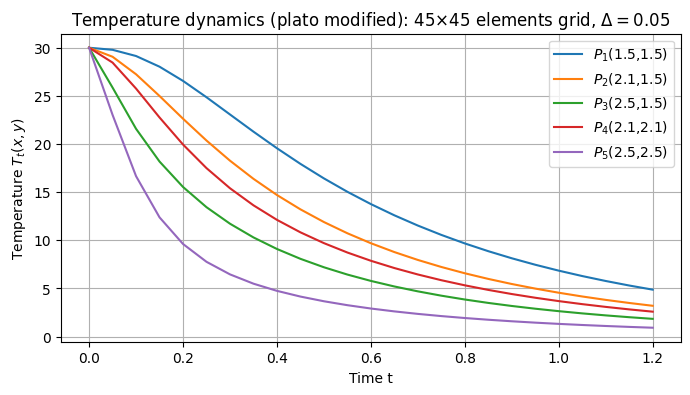

Temperature dynamics (plato modified), 45*45 elements grid, delta = 0.2667, dt = 0.05:
P1(1.5,1.5) [30.0, 29.782621577367248, 29.138550973563376, 28.029452818697905, 26.553841325289838, 24.856246773094075, 23.067169355086286, 21.281834773912113, 19.560714337736226, 17.93757758841595, 16.428074549729388, 15.036511969581822, 13.76056291990779, 12.594315845598777, 11.530156672374588, 10.559885128910732, 9.675348704896601, 8.868781341357376, 8.132965748389147, 7.461293121145078, 6.847765240752403, 6.286965976382642, 5.7740181402288275, 5.304534905237996, 4.874570926785019]
P2(2.1,1.5) [30.0, 29.060376642180856, 27.24389472396606, 24.985466587713663, 22.627402608146657, 20.35972234842842, 18.268869253136437, 16.38358218297888, 14.703280415063478, 13.213863972825996, 11.89610252971738, 10.72988210413896, 9.696199130013703, 8.777965658786922, 7.960212751926143, 7.230008739992306, 6.576258462415592, 5.98946739640121, 5.461510630485122, 4.985423709745462, 4.555220814754742, 4.165740207696145, 3

,0.0,0.2,0.4,0.6,0.8,1.0,1.2
"P1[1.5, 1.5]",30.0,26.553841,19.560714,13.760563,9.675349,6.847765,4.874571
"P2[2.1, 1.5]",30.0,22.627403,14.703280,9.696199,6.576258,4.555221,3.199799
"P3[2.5, 1.5]",30.0,15.538068,9.098194,5.782329,3.851465,2.640524,1.843278
"P4[2.1, 2.1]",30.0,19.946673,12.122753,7.873810,5.324160,3.685765,2.588761
"P5[2.5, 2.5]",30.0,9.617192,4.750652,2.915548,1.928839,1.320670,0.921694


In [132]:
Numerical_P_points = [
    [Ut_anchor_points[t][point] for t in range(len(Trange)+1)] for point in range(len(Ut_anchor_points[0]))
]

Numerical_results_dataframe = display_temperature_distribution_dataframe(Numerical_P_points,Ut_anchor_points)
print(f"\nTemperature dynamics ({U0_type}) at the specific time points, {Nx-1}*{Ny-1} elements grid, delta = {round(delta,4)}, dt = {dt}:")
Numerical_results_dataframe

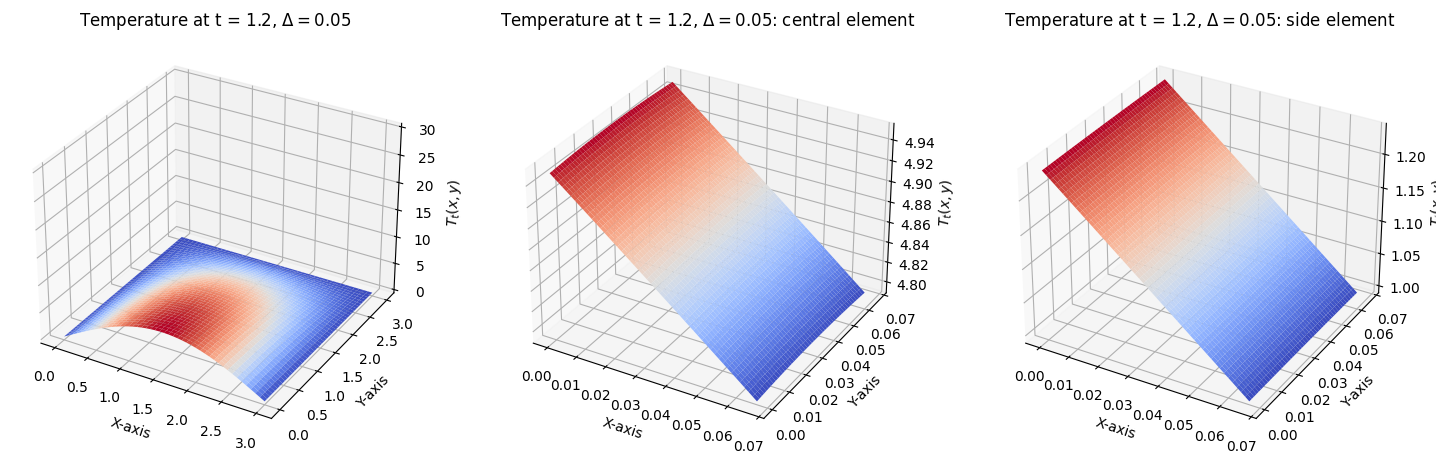

In [133]:
points_per_element = 50
display_temperature_distribution_at_last_moment(T_distribution,X_anchor,points_per_element)

#### 5.3. Compare numerical and Fourier analytical results

In [134]:
print("Fourier analytical results:")
if U0_type == "Gauss":
    Fourier_results_dataframe = joblib.load("Dataframes/Fourier --Gauss-- temperature dataframe N*M:30*30.joblib")
if U0_type == "plato":
    Fourier_results_dataframe = joblib.load("Dataframes/Fourier --plato-- temperature dataframe N*M:30*30.joblib")
if U0_type == "plato modified":
    Fourier_results_dataframe = joblib.load("Dataframes/Fourier --plato modified-- temperature dataframe N*M:30*30.joblib")
Fourier_results_dataframe

Fourier analytical results:


,U0 exact,0.0,0.2,0.4,0.6,0.8,1.0,1.2
"P1[1.5, 1.5]",30.0,30.627744,27.018395,19.046076,13.068482,9.053621,6.331162,4.454511
"P2[2.1, 1.5]",30.0,31.050062,22.286581,13.890949,9.016647,6.061816,4.165937,2.901291
"P3[2.5, 1.5]",30.0,31.711100,14.556460,8.418046,5.315718,3.523893,2.402388,1.665187
"P4[2.1, 2.1]",30.0,31.201296,18.980651,11.302694,7.299287,4.904462,3.370341,2.347196
"P5[2.5, 2.5]",30.0,32.360986,8.121261,4.261620,2.661550,1.762219,1.201215,0.832595


In [135]:
print("Difference between MSS and Fourier:")
abs(round(Numerical_results_dataframe,6)-round(Fourier_results_dataframe,6))

Difference between MSS and Fourier:


,0.0,0.2,0.4,0.6,0.8,1.0,1.2,U0 exact
"P1[1.5, 1.5]",0.627744,0.464554,0.514638,0.692081,0.621728,0.516603,0.420060,NaN
"P2[2.1, 1.5]",1.050062,0.340822,0.812331,0.679552,0.514442,0.389284,0.298508,NaN
"P3[2.5, 1.5]",1.711100,0.981608,0.680148,0.466611,0.327572,0.238136,0.178091,NaN
"P4[2.1, 2.1]",1.201296,0.966022,0.820059,0.574523,0.419698,0.315424,0.241565,NaN
"P5[2.5, 2.5]",2.360986,1.495931,0.489032,0.253998,0.166620,0.119455,0.089099,NaN


In [136]:
Fourier_central_point = Fourier_results_dataframe.iloc[0][1:].values
Fourier_Trange = np.array(Fourier_results_dataframe.keys()[2:].astype(np.float64))

if len(Trange) == len(Fourier_Trange):
    plt.figure(figsize=(8,4))

    plt.plot(np.insert(arr=Trange, obj=0, values=0), Fourier_central_point, "o-", linewidth=1)
    plt.plot(np.insert(arr=Trange, obj=0, values=0), Numerical_P_points[0], "o-", linewidth=1)
    plt.legend(["Analytical Fourier method", "Numerical MMS method"])

    plt.grid()
    plt.ylabel(r"Temperature $T_t(x,y)$")
    plt.xlabel("Time t")

    plt.title(r"Temperature dynamics for central point, " + f"{Nx-1}" + r"$\times$" + f"{Ny-1} elements grid")

    plt.savefig(f"Images/MSS: {U0_type} comparison with Fourier in central point.png", dpi=500, bbox_inches="tight")
    plt.show()

#### 5.4. Gauss log error plot

In [137]:
Fourier_P1 = 0.666695

delta_time_15_times_15 = np.array([0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.25])
numerical_15_times_15 = np.array([0.667997, 0.668021, 0.668296, 0.668938, 0.670338, 0.674572, 0.681352, 0.724307])

delta_time = np.array([0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.25])
numerical_25_times_25 = np.array([0.667188, 0.667206, 0.667310, 0.667715, 0.668436, 0.669891, 0.674174, 0.680985, 0.724061])
numerical_45_times_45 = np.array([0.666848, 0.666936, 0.667077, 0.667518, 0.668256, 0.669721, 0.674012, 0.680831, 0.723948])
numerical_65_times_65 = np.array([0.666776, 0.666884, 0.667031, 0.667476, 0.668215, 0.669681, 0.673974, 0.680795, 0.723920])

delta_time_105_times_105 = np.array([5e-05, 0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.25])
numerical_105_times_105 = np.array([0.666728, 0.666741, 0.666858, 0.667007, 0.667453, 0.668193, 0.669659, 0.673953, 0.680774, 0.723904])

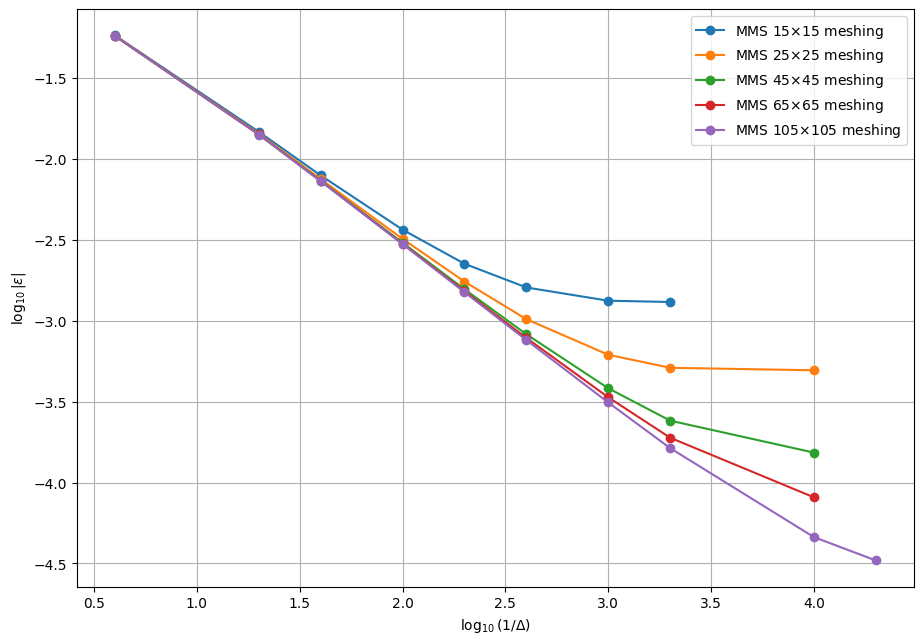

In [138]:
plt.figure(figsize=(4*2.7,3*2.5))

plt.plot(np.log10(1/delta_time_15_times_15), np.log10(numerical_15_times_15-Fourier_P1), "o-")
plot_25_times_25 = plt.plot(np.log10(1/delta_time), np.log10(numerical_25_times_25-Fourier_P1), "o-")
plot_45_times_45 = plt.plot(np.log10(1/delta_time), np.log10(numerical_45_times_45-Fourier_P1), "o-")
plot_65_times_65 = plt.plot(np.log10(1/delta_time), np.log10(numerical_65_times_65-Fourier_P1), "o-")
plot_105_times_105 = plt.plot(np.log10(1/delta_time_105_times_105), np.log10(numerical_105_times_105-Fourier_P1), "o-")

line_color_105_times_105 = plot_105_times_105[0].get_color()

plt.grid()
plt.xlabel(r"$\log_{10}(1/\Delta)$")
plt.ylabel(r"$\log_{10}|\varepsilon|$")

plt.legend([r"MMS 15$\times 15$ meshing",r"MMS 25$\times 25$ meshing",r"MMS 45$\times 45$ meshing",r"MMS 65$\times 65$ meshing",r"MMS 105$\times 105$ meshing"])
plt.savefig("Images/MSS: log scale error.png", dpi=700, bbox_inches="tight")
plt.show()

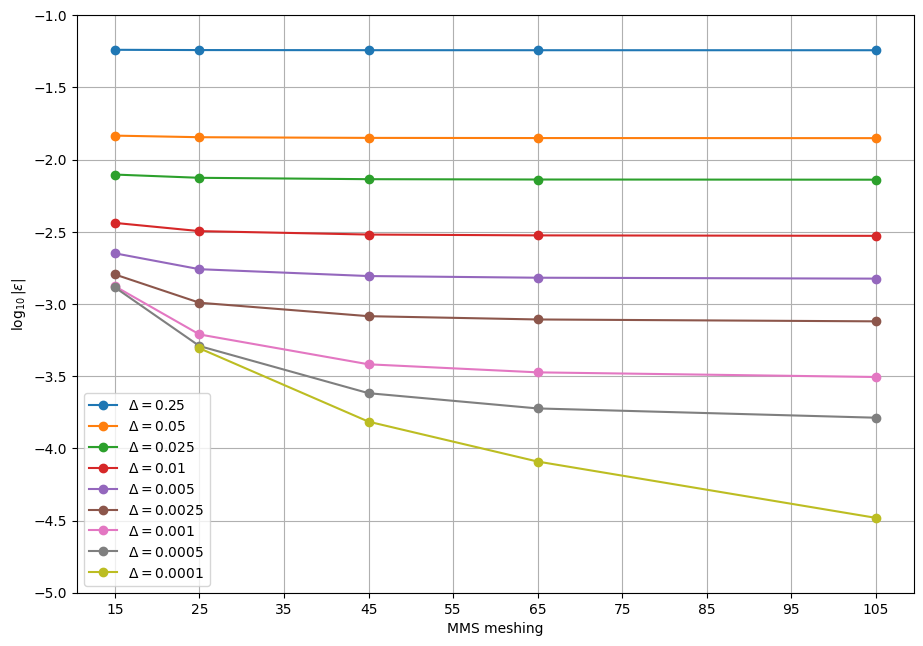

In [139]:
plt.figure(figsize=(4*2.7,3*2.5))

for time_index in range(-1,-len(delta_time),-1):
    plt.plot(
        [15,25,45,65,105], 
        [np.log10(numerical[time_index]-Fourier_P1) for numerical in [numerical_15_times_15,numerical_25_times_25,numerical_45_times_45,numerical_65_times_65,numerical_105_times_105]], 
        "o-"
    )

plt.plot(
    [25,45,65,105], 
    [np.log10(numerical[0]-Fourier_P1) for numerical in [numerical_25_times_25,numerical_45_times_45,numerical_65_times_65,numerical_105_times_105]], 
    "o-"
)

plt.grid()
plt.xlabel(r"MMS meshing")
plt.ylabel(r"$\log_{10}|\varepsilon|$")
plt.xticks(np.arange(start=15,stop=106,step=10))
plt.ylim(bottom=-5,top=-1)

plt.legend([r"$\Delta=$"+f"{delta_time[time_index]}" for time_index in range(-1,-len(delta_time)-1,-1)],loc='best')
plt.savefig("Images/MSS: log scale delta time error.png", dpi=700, bbox_inches="tight")
plt.show()

#### 5.5. Gauss ABAQUS log error plot

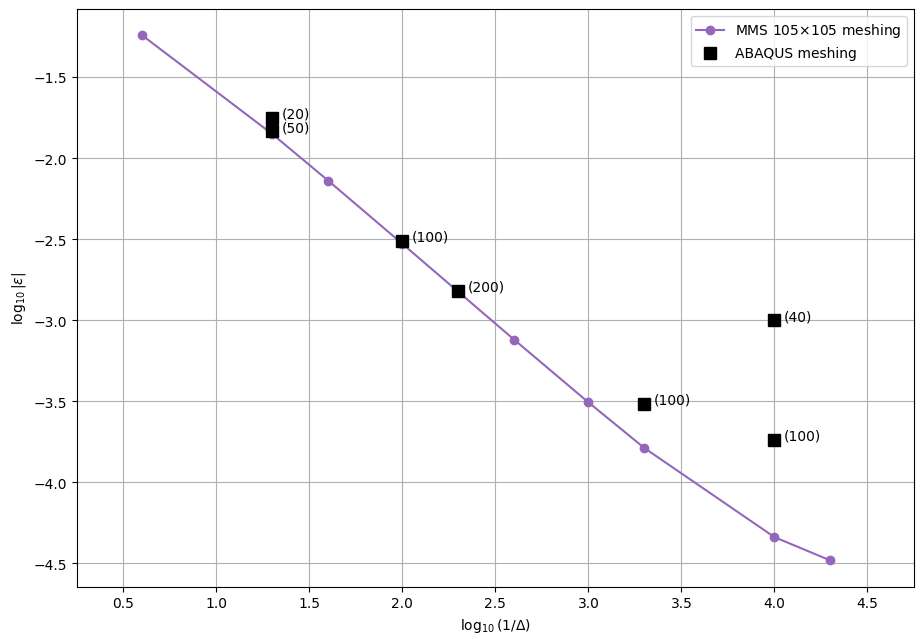

In [140]:
delta_time_abacus = np.array([0.05, 0.05, 0.01, 0.005, 0.0005, 0.0001, 0.0001])
Nx_abacus = np.array([20, 50, 100, 200, 100, 40, 100])
numerical_abacus = np.array([0.684410, 0.681343, 0.669798, 0.668217, 0.666999, 0.667695, 0.666879])

plt.figure(figsize=(4*2.7,3*2.5))

plt.plot(np.log10(1/delta_time_105_times_105), np.log10(numerical_105_times_105-Fourier_P1), "o-", color=f"{line_color_105_times_105}")
plt.plot(np.log10(1/delta_time_abacus), np.log10(numerical_abacus-Fourier_P1), "s", color="black", ms=8)

for x,y,label in zip(np.log10(1/delta_time_abacus),np.log10(numerical_abacus-Fourier_P1),Nx_abacus):
    plt.annotate(f"({label})",(x,y),textcoords="offset points",xytext=(7,0))

plt.grid()
plt.xlabel(r"$\log_{10}(1/\Delta)$")
plt.ylabel(r"$\log_{10}|\varepsilon|$")

plt.xlim(0.25,4.75)

plt.legend([r"MMS 105$\times 105$ meshing",r"ABAQUS meshing"])
plt.savefig("Images/MSS: log abaqus scale error.png", dpi=700, bbox_inches="tight")
plt.show()